##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c06_forecasting_with_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c06_forecasting_with_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

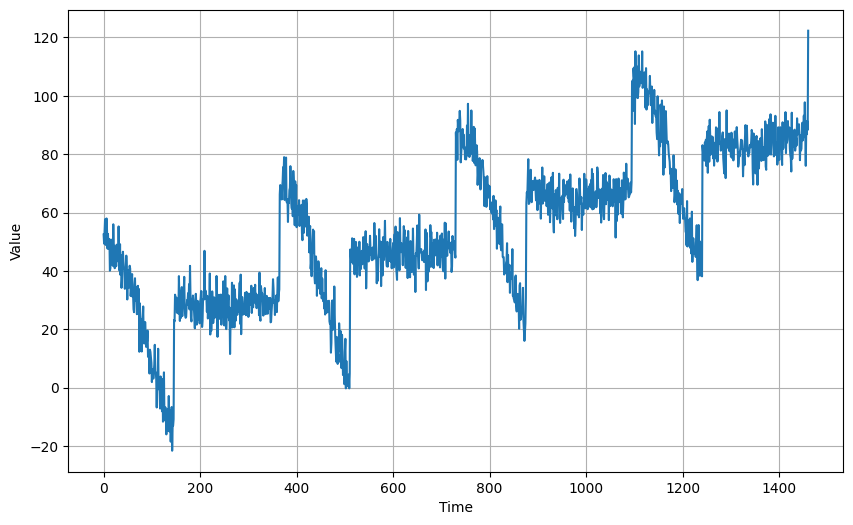

In [4]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Simple RNN Forecasting

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 154.1519 - mae: 154.6519 - learning_rate: 1.0000e-07
Epoch 2/100
1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - loss: 119.9347 - mae: 120.4347

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 100.2396 - mae: 100.7396 - learning_rate: 1.1220e-07
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 26.3593 - mae: 26.8568 - learning_rate: 1.2589e-07
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 31.5069 - mae: 32.0060 - learning_rate: 1.4125e-07
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 16.4130 - mae: 16.9018 - learning_rate: 1.5849e-07
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 15.4761 - mae: 15.9694 - learning_rate: 1.7783e-07
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 13.9384 - mae: 14.4311 - learning_rate: 1.9953e-07
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 13.9250 - mae: 14.4146 - learning_rate: 2.2387e-07
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 13.2779 - mae: 13.7654 - learning_rate: 2.5119e-07
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 12.3456 - mae: 12.8290 - learning_rate: 2.8184e-07
Epoch 11/100
8/8 ━━━━━━━━━━━

(np.float64(1e-07), np.float64(0.0001), np.float64(0.0), np.float64(30.0))

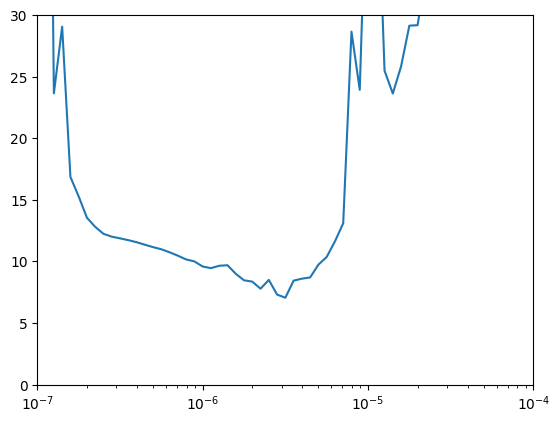

In [7]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(learning_rate=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


      7/Unknown 3s 38ms/step - loss: 48.1207 - mae: 48.6180

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 47.5229 - mae: 48.0203 - val_loss: 40.7718 - val_mae: 41.2703
Epoch 2/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 34.2811 - mae: 34.7794

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 33.1531 - mae: 33.6512 - val_loss: 16.7743 - val_mae: 17.2706
Epoch 3/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 18.7935 - mae: 19.2828

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 18.0335 - mae: 18.5231 - val_loss: 11.0601 - val_mae: 11.5524
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 11.6042 - mae: 12.0915 - val_loss: 11.9928 - val_mae: 12.4886
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 10.5641 - mae: 11.0510 - val_loss: 19.2560 - val_mae: 19.7536
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 12.5384 - mae: 13.0279 - val_loss: 13.7835 - val_mae: 14.2779
Epoch 7/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 9.9131 - mae: 10.3996

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 9.8880 - mae: 10.3746 - val_loss: 10.9905 - val_mae: 11.4829
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 9.4389 - mae: 9.9269 - val_loss: 16.2222 - val_mae: 16.7191
Epoch 9/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 9.6203 - mae: 10.1095 - val_loss: 14.7729 - val_mae: 15.2671
Epoch 10/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 9.2558 - mae: 9.7431

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 9.1815 - mae: 9.6686 - val_loss: 8.6984 - val_mae: 9.1908
Epoch 11/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 8.9146 - mae: 9.4002 - val_loss: 12.9370 - val_mae: 13.4290
Epoch 12/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 8.0713 - mae: 8.5561 - val_loss: 11.0436 - val_mae: 11.5336
Epoch 13/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 7.8805 - mae: 8.3636

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - loss: 7.8631 - mae: 8.3461 - val_loss: 8.2196 - val_mae: 8.7078
Epoch 14/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 7.8142 - mae: 8.2939 - val_loss: 9.7614 - val_mae: 10.2527
Epoch 15/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 7.3001 - mae: 7.7766

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 7.3147 - mae: 7.7915 - val_loss: 6.9684 - val_mae: 7.4493
Epoch 16/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 7.1309 - mae: 7.6119 - val_loss: 8.2808 - val_mae: 8.7673
Epoch 17/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 7.0285 - mae: 7.5105

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 7.0315 - mae: 7.5133 - val_loss: 6.8963 - val_mae: 7.3786
Epoch 18/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 6.8877 - mae: 7.3674 - val_loss: 8.1637 - val_mae: 8.6532
Epoch 19/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 7.2575 - mae: 7.7454 - val_loss: 7.3311 - val_mae: 7.8169
Epoch 20/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - loss: 6.7835 - mae: 7.2644 - val_loss: 7.6700 - val_mae: 8.1546
Epoch 21/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 6.4671 - mae: 6.9387

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 6.5427 - mae: 7.0156 - val_loss: 6.0412 - val_mae: 6.5223
Epoch 22/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 7.2704 - mae: 7.7453

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 7.1599 - mae: 7.6352 - val_loss: 5.7925 - val_mae: 6.2732
Epoch 23/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 7.2081 - mae: 7.6871 - val_loss: 7.6965 - val_mae: 8.1773
Epoch 24/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - loss: 6.8518 - mae: 7.3308 - val_loss: 6.2772 - val_mae: 6.7576
Epoch 25/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 6.6824 - mae: 7.1623 - val_loss: 6.7367 - val_mae: 7.2244
Epoch 26/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 6.7764 - mae: 7.2538 - val_loss: 6.4404 - val_mae: 6.9223
Epoch 27/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 6.2354 - mae: 6.7143 - val_loss: 6.4841 - val_mae: 6.9667
Epoch 28/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 6.2585 - mae: 6.7402 - val_loss: 5.8094 - val_mae: 6.2899
Epoch 29/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - loss: 6.2907 - mae: 6.7720 - val_loss: 7.1514 - val_mae: 7.6356
Epoch 30/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 6.5359 - mae: 7.

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 6.4847 - mae: 6.9701 - val_loss: 5.6020 - val_mae: 6.0799
Epoch 31/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 6.5874 - mae: 7.0669 - val_loss: 8.6835 - val_mae: 9.1764
Epoch 32/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 7.2715 - mae: 7.7491

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 7.1493 - mae: 7.6272 - val_loss: 5.5608 - val_mae: 6.0417
Epoch 33/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 7.0768 - mae: 7.5598 - val_loss: 6.7588 - val_mae: 7.2491
Epoch 34/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 6.4580 - mae: 6.9370 - val_loss: 7.3218 - val_mae: 7.8039
Epoch 35/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 6.3355 - mae: 6.8168 - val_loss: 5.7363 - val_mae: 6.2158
Epoch 36/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 6.5036 - mae: 6.9795 - val_loss: 6.4881 - val_mae: 6.9711
Epoch 37/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 6.3697 - mae: 6.8507 - val_loss: 5.6440 - val_mae: 6.1241
Epoch 38/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 6.1362 - mae: 6.6145 - val_loss: 6.4849 - val_mae: 6.9690
Epoch 39/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 5.7045 - mae: 6.1830 - val_loss: 6.0205 - val_mae: 6.4972
Epoch 40/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 5.7719 - mae: 6.

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 5.9306 - mae: 6.4108 - val_loss: 5.4812 - val_mae: 5.9599
Epoch 42/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 5.9861 - mae: 6.4656 - val_loss: 7.7592 - val_mae: 8.2411
Epoch 43/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 5.9868 - mae: 6.4662 - val_loss: 5.6321 - val_mae: 6.1145
Epoch 44/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 6.1580 - mae: 6.6332 - val_loss: 5.6378 - val_mae: 6.1204
Epoch 45/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 6.0668 - mae: 6.5456 - val_loss: 6.7100 - val_mae: 7.1942
Epoch 46/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 6.0035 - mae: 6.4815 - val_loss: 5.6725 - val_mae: 6.1555
Epoch 47/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 6.0411 - mae: 6.5180 - val_loss: 6.1724 - val_mae: 6.6548
Epoch 48/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 5.8783 - mae: 6.3586 - val_loss: 7.8014 - val_mae: 8.2862
Epoch 49/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 5.9021 - mae: 6.38

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 5.6951 - mae: 6.1763 - val_loss: 5.4174 - val_mae: 5.8981
Epoch 56/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 5.6438 - mae: 6.1230 - val_loss: 5.9049 - val_mae: 6.3819
Epoch 57/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 5.6224 - mae: 6.1070 - val_loss: 6.1723 - val_mae: 6.6558
Epoch 58/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 5.6958 - mae: 6.1777 - val_loss: 6.1292 - val_mae: 6.6106
Epoch 59/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 5.5734 - mae: 6.0460 - val_loss: 6.3190 - val_mae: 6.8039
Epoch 60/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 5.7695 - mae: 6.2511 - val_loss: 6.2062 - val_mae: 6.6902
Epoch 61/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 5.2186 - mae: 5.6891 - val_loss: 5.5587 - val_mae: 6.0414
Epoch 62/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 5.6423 - mae: 6.1200 - val_loss: 6.2158 - val_mae: 6.7004
Epoch 63/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 5.5719 - mae: 6.04

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 5.5774 - mae: 6.0554 - val_loss: 5.3487 - val_mae: 5.8248
Epoch 64/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 5.3936 - mae: 5.8715 - val_loss: 5.4868 - val_mae: 5.9683
Epoch 65/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 5.4422 - mae: 5.9209 - val_loss: 5.5655 - val_mae: 6.0472
Epoch 66/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 5.1165 - mae: 5.5976 - val_loss: 6.8802 - val_mae: 7.3669
Epoch 67/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 5.4962 - mae: 5.9745 - val_loss: 5.5899 - val_mae: 6.0719
Epoch 68/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 5.2539 - mae: 5.7301 - val_loss: 5.5459 - val_mae: 6.0272
Epoch 69/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 5.1489 - mae: 5.6283 - val_loss: 5.6590 - val_mae: 6.1396
Epoch 70/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 5.1327 - mae: 5.6112 - val_loss: 5.3898 - val_mae: 5.8674
Epoch 71/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 5.6678 - mae: 6.

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 5.6987 - mae: 6.1833 - val_loss: 5.3322 - val_mae: 5.8161
Epoch 75/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 5.5535 - mae: 6.0299 - val_loss: 7.0501 - val_mae: 7.5345
Epoch 76/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - loss: 5.3774 - mae: 5.8539 - val_loss: 5.9533 - val_mae: 6.4314
Epoch 77/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 5.1352 - mae: 5.6107 - val_loss: 5.9631 - val_mae: 6.4414
Epoch 78/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 5.5420 - mae: 6.0162 - val_loss: 6.2846 - val_mae: 6.7665
Epoch 79/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 5.3424 - mae: 5.8221

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 5.4029 - mae: 5.8825 - val_loss: 5.2888 - val_mae: 5.7718
Epoch 80/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 5.9671 - mae: 6.4465 - val_loss: 5.7506 - val_mae: 6.2293
Epoch 81/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 5.5563 - mae: 6.0398 - val_loss: 6.1714 - val_mae: 6.6547
Epoch 82/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 5.0221 - mae: 5.4998 - val_loss: 5.6403 - val_mae: 6.1212
Epoch 83/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 5.2166 - mae: 5.6925 - val_loss: 6.4211 - val_mae: 6.9029
Epoch 84/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 5.2321 - mae: 5.7127 - val_loss: 5.4932 - val_mae: 5.9746
Epoch 85/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 5.1781 - mae: 5.6565 - val_loss: 5.8027 - val_mae: 6.2809
Epoch 86/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 5.1096 - mae: 5.5851 - val_loss: 5.5344 - val_mae: 6.0153
Epoch 87/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 5.4015 - mae: 5.

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 5.1496 - mae: 5.6213 - val_loss: 5.2783 - val_mae: 5.7595
Epoch 89/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 5.1077 - mae: 5.5839 - val_loss: 6.7930 - val_mae: 7.2788
Epoch 90/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 5.3005 - mae: 5.7734 - val_loss: 6.4075 - val_mae: 6.8880
Epoch 91/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 5.6145 - mae: 6.0889 - val_loss: 5.4399 - val_mae: 5.9230
Epoch 92/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 5.8156 - mae: 6.2960 - val_loss: 8.3778 - val_mae: 8.8662
Epoch 93/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 5.7308 - mae: 6.2126 - val_loss: 5.2878 - val_mae: 5.7715
Epoch 94/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 5.5017 - mae: 5.9780 - val_loss: 6.3282 - val_mae: 6.8093
Epoch 95/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 5.4213 - mae: 5.9034 - val_loss: 8.8735 - val_mae: 9.3672
Epoch 96/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 6.4598 - mae: 6.94

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 6.3162 - mae: 6.8012 - val_loss: 5.2574 - val_mae: 5.7382
Epoch 97/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 5.2816 - mae: 5.7599 - val_loss: 8.2296 - val_mae: 8.7158
Epoch 98/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 5.8968 - mae: 6.3768 - val_loss: 5.3144 - val_mae: 5.7982
Epoch 99/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 5.2515 - mae: 5.7283 - val_loss: 5.5403 - val_mae: 6.0209
Epoch 100/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 4.9745 - mae: 5.4548 - val_loss: 5.2928 - val_mae: 5.7707
Epoch 101/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 4.9605 - mae: 5.4349 - val_loss: 6.0438 - val_mae: 6.5243
Epoch 102/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 5.0239 - mae: 5.5014 - val_loss: 5.8582 - val_mae: 6.3356
Epoch 103/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 4.5456 - mae: 5.0194 - val_loss: 5.4697 - val_mae: 5.9497
Epoch 104/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 4.6480 - mae

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 5.1113 - mae: 5.5873 - val_loss: 5.2407 - val_mae: 5.7176
Epoch 110/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 4.8914 - mae: 5.3682 - val_loss: 6.8683 - val_mae: 7.3532
Epoch 111/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 5.0482 - mae: 5.5243

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 5.0210 - mae: 5.4972 - val_loss: 5.1409 - val_mae: 5.6245
Epoch 112/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 4.9158 - mae: 5.3925 - val_loss: 5.1716 - val_mae: 5.6483
Epoch 113/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 4.9112 - mae: 5.3772 - val_loss: 6.7220 - val_mae: 7.2084
Epoch 114/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 5.1181 - mae: 5.5922 - val_loss: 5.7436 - val_mae: 6.2277
Epoch 115/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 5.6494 - mae: 6.1282 - val_loss: 10.1671 - val_mae: 10.6610
Epoch 116/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 6.5040 - mae: 6.9882 - val_loss: 5.4776 - val_mae: 5.9557
Epoch 117/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 5.8330 - mae: 6.3116 - val_loss: 7.0657 - val_mae: 7.5506
Epoch 118/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 5.1702 - mae: 5.6443 - val_loss: 5.1913 - val_mae: 5.6705
Epoch 119/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - loss: 4.8097 

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 5.0487 - mae: 5.5268 - val_loss: 5.1294 - val_mae: 5.6058
Epoch 134/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 4.9100 - mae: 5.3807 - val_loss: 5.6846 - val_mae: 6.1662
Epoch 135/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 4.7771 - mae: 5.2544 - val_loss: 5.1537 - val_mae: 5.6317
Epoch 136/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 4.7414 - mae: 5.2135 - val_loss: 5.8153 - val_mae: 6.2932
Epoch 137/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.7710 - mae: 5.2443

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.7496 - mae: 5.2229 - val_loss: 5.1223 - val_mae: 5.6058
Epoch 138/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.8168 - mae: 5.2933 - val_loss: 6.0080 - val_mae: 6.4838
Epoch 139/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 4.9482 - mae: 5.4227 - val_loss: 5.5243 - val_mae: 6.0043
Epoch 140/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 4.9899 - mae: 5.4697 - val_loss: 5.1660 - val_mae: 5.6496
Epoch 141/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 5.5221 - mae: 6.0022 - val_loss: 9.0270 - val_mae: 9.5189
Epoch 142/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 5.9154 - mae: 6.3978 - val_loss: 6.1760 - val_mae: 6.6626
Epoch 143/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 5.8879 - mae: 6.3673 - val_loss: 10.0232 - val_mae: 10.5178
Epoch 144/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 6.1751 - mae: 6.6561 - val_loss: 5.1484 - val_mae: 5.6308
Epoch 145/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - loss: 5.0145 

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 4.9034 - mae: 5.3801 - val_loss: 5.1170 - val_mae: 5.5972
Epoch 148/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 4.8091 - mae: 5.2824 - val_loss: 7.3597 - val_mae: 7.8478
Epoch 149/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 4.7021 - mae: 5.1765 - val_loss: 5.2121 - val_mae: 5.6915
Epoch 150/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.8178 - mae: 5.2919 - val_loss: 5.6512 - val_mae: 6.1325
Epoch 151/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 4.9199 - mae: 5.3899 - val_loss: 6.5696 - val_mae: 7.0545
Epoch 152/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 4.9585 - mae: 5.4319 - val_loss: 5.5109 - val_mae: 5.9903
Epoch 153/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 4.7116 - mae: 5.1856 - val_loss: 5.3113 - val_mae: 5.7888
Epoch 154/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 4.6032 - mae: 5.0799 - val_loss: 7.0829 - val_mae: 7.5695
Epoch 155/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 4.6387 - 

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 5.0524 - mae: 5.5281 - val_loss: 5.0703 - val_mae: 5.5525
Epoch 159/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 4.8270 - mae: 5.3038 - val_loss: 5.9213 - val_mae: 6.3953
Epoch 160/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.9341 - mae: 5.4114 - val_loss: 5.1177 - val_mae: 5.6013
Epoch 161/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - loss: 4.7179 - mae: 5.1898 - val_loss: 6.2306 - val_mae: 6.7105
Epoch 162/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 4.5272 - mae: 4.9971 - val_loss: 5.8768 - val_mae: 6.3535
Epoch 163/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - loss: 4.5393 - mae: 5.0132 - val_loss: 5.1780 - val_mae: 5.6590
Epoch 164/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 4.6742 - mae: 5.1533 - val_loss: 5.1762 - val_mae: 5.6574
Epoch 165/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 4.4958 - mae: 4.9700 - val_loss: 5.1610 - val_mae: 5.6425
Epoch 166/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 4.6146 -

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 4.6722 - mae: 5.1504 - val_loss: 5.0276 - val_mae: 5.5127
Epoch 191/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - loss: 4.5426 - mae: 5.0166 - val_loss: 5.9232 - val_mae: 6.3978
Epoch 192/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 4.6654 - mae: 5.1415 - val_loss: 5.7834 - val_mae: 6.2578
Epoch 193/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 4.5035 - mae: 4.9778 - val_loss: 5.1538 - val_mae: 5.6331
Epoch 194/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 4.7306 - mae: 5.2042 - val_loss: 5.6400 - val_mae: 6.1192
Epoch 195/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 4.4303 - mae: 4.9018 - val_loss: 5.2122 - val_mae: 5.6907
Epoch 196/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 5.2203 - mae: 5.6987 - val_loss: 5.3265 - val_mae: 5.8008
Epoch 197/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.4982 - mae: 4.9743 - val_loss: 5.8514 - val_mae: 6.3257
Epoch 198/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 4.9947 

In [16]:
model.load_weights("my_checkpoint.h5")

In [17]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


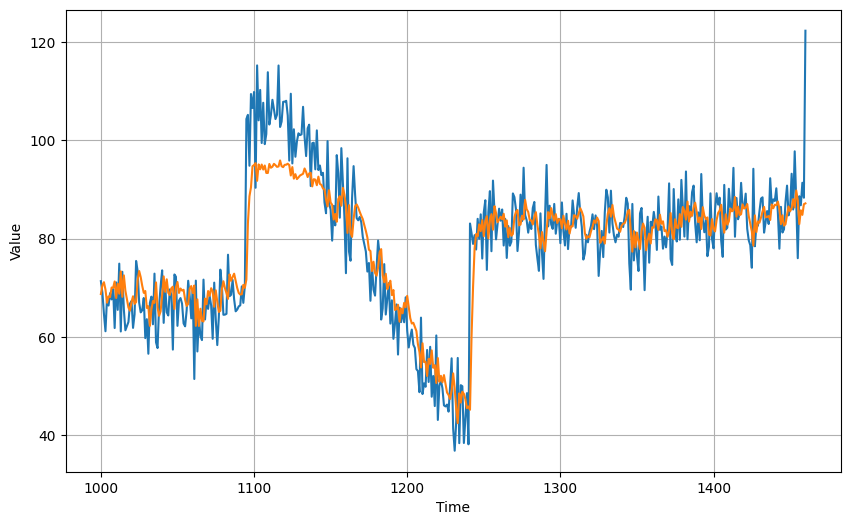

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [20]:
keras.metrics.mae(x_valid, rnn_forecast).numpy()

np.float32(5.4572325)

## Sequence-to-Sequence Forecasting

In [21]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [22]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]


In [23]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 56.0774 - mae: 56.5771 - learning_rate: 1.0000e-07
Epoch 2/100
1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 41.0603 - mae: 41.5596

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 32.8177 - mae: 33.3156 - learning_rate: 1.0798e-07
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 19.5280 - mae: 20.0221 - learning_rate: 1.1659e-07
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 20.1592 - mae: 20.6538 - learning_rate: 1.2589e-07
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 17.2016 - mae: 17.6945 - learning_rate: 1.3594e-07
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 16.5544 - mae: 17.0470 - learning_rate: 1.4678e-07
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 15.7768 - mae: 16.2674 - learning_rate: 1.5849e-07
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 15.3859 - mae: 15.8752 - learning_rate: 1.7113e-07
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 14.7690 - mae: 15.2592 - learning_rate: 1.8478e-07
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 14.2152 - mae: 14.7054 - learning_rate: 1.9953e-07
Epoch 11/100
8/8 ━━━━━━━━━━━━━

(np.float64(1e-07), np.float64(0.0001), np.float64(0.0), np.float64(30.0))

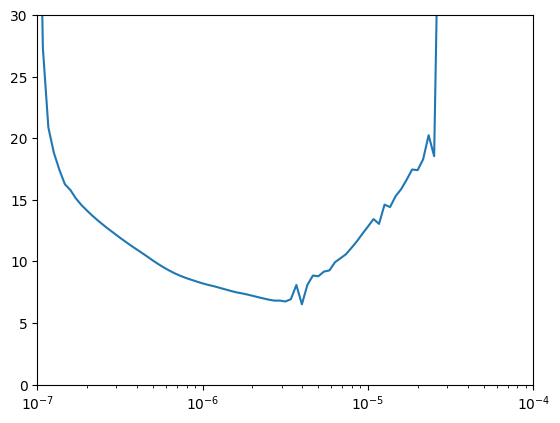

In [24]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [25]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 21.5025 - mae: 21.9949 - val_loss: 15.1122 - val_mae: 15.6047
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 17.2482 - mae: 17.7392 - val_loss: 12.8766 - val_mae: 13.3692
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 14.5637 - mae: 15.0523 - val_loss: 20.0310 - val_mae: 20.5243
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 13.2055 - mae: 13.6934 - val_loss: 11.6796 - val_mae: 12.1674
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 11.4242 - mae: 11.9105 - val_loss: 9.8964 - val_mae: 10.3846
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 10.4221 - mae: 10.9077 - val_loss: 8.9476 - val_mae: 9.4318
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 9.5392 - mae: 10.0250 - val_loss: 7.3029 - val_mae: 7.7873
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - loss: 9.1333 - mae: 9.6190 - val_loss: 7.2471 - val_mae: 7.7282
Epoch 9/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/ste

In [26]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


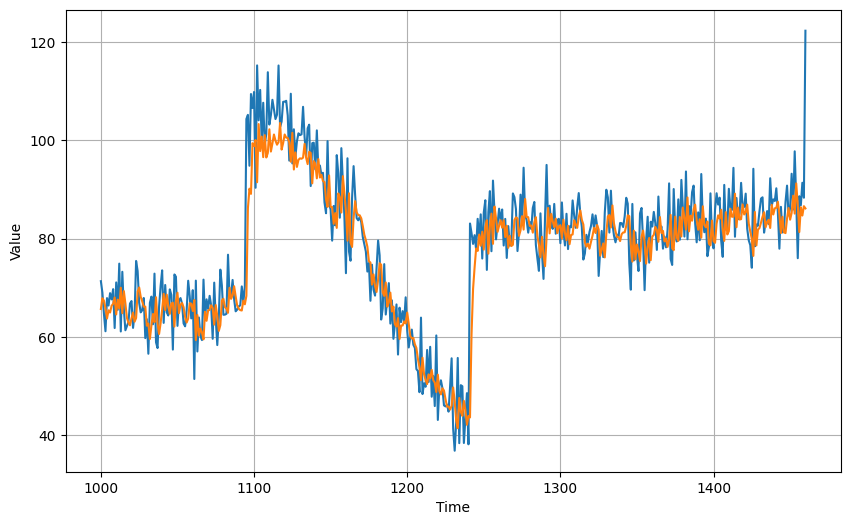

In [27]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [28]:
keras.metrics.mae(x_valid, rnn_forecast).numpy()

np.float32(5.1257367)